VAEs dynamiques : https://arxiv.org/abs/2008.12595

# Training a GP-VAE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
import sys
import os

# Add the parent directory to sys.path to find the libs module
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
print(f"Added {parent_dir} to Python path")
print(f"Current working directory: {os.getcwd()}")
print(f"Python path: {sys.path}")

# Now libs.gpvae_lib should be importable

Added /home/benjamin.deporte/MVA/MVA_Stage to Python path
Current working directory: /home/benjamin.deporte/MVA/MVA_Stage/notebooks
Python path: ['/home/benjamin.deporte/MVA/MVA_Stage/notebooks', '/home/benjamin.deporte/.conda/envs/torchy/lib/python312.zip', '/home/benjamin.deporte/.conda/envs/torchy/lib/python3.12', '/home/benjamin.deporte/.conda/envs/torchy/lib/python3.12/lib-dynload', '', '/home/benjamin.deporte/.conda/envs/torchy/lib/python3.12/site-packages', '/home/benjamin.deporte/.conda/envs/torchy/lib/python3.12/site-packages/setuptools/_vendor', '/home/benjamin.deporte/MVA/MVA_Stage']


In [60]:
from libs.gpvae_lib import seed_everything
from libs.gpvae_lib import Encoder, GaussianDecoder, GaussianProcessPriorMaison
from libs.gpvae_lib import DecoderMean, make_mlp, GPNullMean, compute_vlb
from libs.gpvae_lib import GaussianKernel, CauchyKernel, RQKernel, MaternKernel
from libs.gpvae_lib import compute_vlb

In [5]:
# Set seed for reproducibility
seed_everything(42)

In [182]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float64)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 4090
Total GPU Memory: 23.6 GB


# Data simplissime

In [246]:
# Dimensions
Dx = 1
Dz = 1

# parameters
N = 100
B = 1

x shape: torch.Size([1, 100])


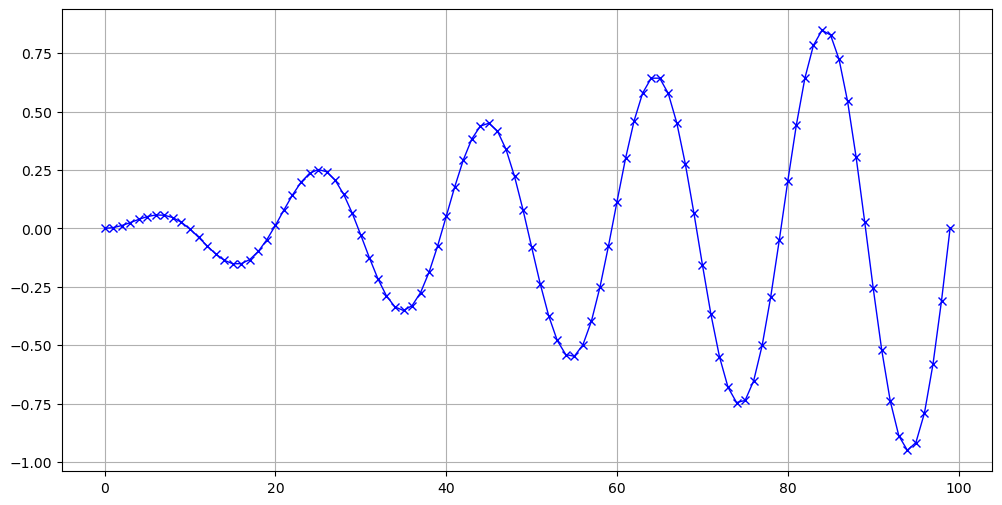

In [247]:
t = torch.linspace(0, 1, N).reshape(1, N).to(device)  # (1, N)
x = t * torch.sin(t * 2 * np.pi * 5)
print(f"x shape: {x.shape}") # (1, N)

fig, ax = plt.subplots(figsize=(12, 6))
# Plot the original time series
ax.plot(x[0, :].detach().cpu().numpy(), label='Original Time Series', color='blue', marker='x', linewidth=1)
ax.grid(True)
plt.show()# Data simplissime

# Modèle

Encoder

In [248]:
encoder = Encoder(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=2,
    inter_dim=16,
    activation=nn.ReLU,
).to(device)

print(encoder)

Encoder, x_dimension=1, z_dimension=1, n_layers=2, inter_dim=16, activation=ReLU
EncoderMean: EncoderMean, x_dimension=1, z_dimension=1, n_layers=2, inter_dim=16, activation=ReLU
EncoderCovariance: EncoderCovariance, x_dimension=1, z_dimension=1, n_layers=2, inter_dim=16, activation=ReLU, epsilon (to ensure PSD)=1.000e-03


Decoder

In [249]:
decoder_mean = DecoderMean(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=4,
    inter_dim=32,
    activation=nn.ReLU,
).to(device)

print(decoder_mean)

decoder_logvar = make_mlp(
    input_dim=N,
    output_dim=N,
    n_layers=4,
    inter_dim=32,
    activation=nn.ReLU,
).to(device)

print(decoder_logvar)

DecoderMean x_dimension=1, z_dimension=1, n_layers=2, inter_dim=16, activation=ReLU
Sequential(
  (0): Linear(in_features=100, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=100, bias=True)
)


Prior Gaussian Process

In [250]:
prior_mean = GPNullMean()
print(prior_mean)

prior_kernel = GaussianKernel()
print(prior_kernel)

GPNullMean
GaussianKernel(lengthscale=1.000e+00, variance (sigma**2)=1.000e+00, sigma=1.000e+00, epsilon=1.000e-03)


# Training

Encode Time Series

In [251]:
mu_phi, sigma_phi, _ = encoder(x.unsqueeze(-1))
# peut etre une erreur dans la construction de q_phi dans l'encoder ?

mu_phi = mu_phi.squeeze(0)  # (B, N, Dz)
sigma_phi = sigma_phi.squeeze(0)  # (B, N, Dz)

q_phi = torch.distributions.MultivariateNormal(
    loc=mu_phi,  # (B, N, Dz)
    covariance_matrix=sigma_phi,  # (B, N, Dz, Dz)
)

print(f"mu_phi shape: {mu_phi.shape}")
print(f"sigma_phi shape: {sigma_phi.shape}")
print(f"q_phi: {q_phi}")
print(f"\tq_phi batch shape: {q_phi.batch_shape}")
print(f"\tq_phi event shape: {q_phi.event_shape}")

mu_phi shape: torch.Size([1, 100])
sigma_phi shape: torch.Size([1, 100, 100])
q_phi: MultivariateNormal(loc: torch.Size([1, 100]), covariance_matrix: torch.Size([1, 100, 100]))
	q_phi batch shape: torch.Size([1])
	q_phi event shape: torch.Size([100])


Sample latent

In [252]:
z_sampled = q_phi.rsample()  # (B, N)
# z_sampled = z_sampled.permute(0, 2, 1)  # (B, N, Dz)
# z_sampled_2 = z_sampled.squeeze(2)  # (B, N)
# z_sampled = z_sampled.unsqueeze(2) # (B, L, Dz)
print(f"z_sampled shape: {z_sampled.shape}")

z_sampled shape: torch.Size([1, 100])


Decode the latent and sample $K$ x's

In [253]:
mu_x = decoder_mean(z_sampled.unsqueeze(-1))  # (B, N, Dx)
mu_x = mu_x.squeeze(2)  # (B, N)
print(f"mu_x shape: {mu_x.shape}")

logvar_x = decoder_logvar(z_sampled)  # (B, N, Dx)
covar_x = torch.diag_embed(logvar_x.exp())  # (B, N, Dx, Dx)
print(f"covar_x shape: {covar_x.shape}")

p_theta_x = torch.distributions.MultivariateNormal(
    loc=mu_x,
    covariance_matrix=covar_x
)
print(f"p_theta_x: {p_theta_x}")
print(f"\tp_theta_x batch shape: {p_theta_x.batch_shape}")
print(f"\tp_theta_x event shape: {p_theta_x.event_shape}")

mu_x shape: torch.Size([1, 100])
covar_x shape: torch.Size([1, 100, 100])
p_theta_x: MultivariateNormal(loc: torch.Size([1, 100]), covariance_matrix: torch.Size([1, 100, 100]))
	p_theta_x batch shape: torch.Size([1])
	p_theta_x event shape: torch.Size([100])


In [254]:
K = 10 # number of samples to draw from the decoder distribution
x_hat = p_theta_x.rsample((K,))  # (K, B, L, Dx)
print(f"x_hat shape ({K} samples): {x_hat.shape}")

x_hat shape (10 samples): torch.Size([10, 1, 100])


Compute the Gaussian Process prior at times t's

In [255]:
mu_z = prior_mean(t)  # (1, N, Dz)
sigma_z, L_z = prior_kernel(t, t)  # (1, N, N)

p_theta_z = torch.distributions.MultivariateNormal(
    loc=mu_z,  # (N, Dz)
    scale_tril=L_z  # (N, N)
)

print(f"mu_z shape: {mu_z.shape}")
print(f"sigma_z shape: {sigma_z.shape}")
print(f"p_theta_z: {p_theta_z}")
print(f"\tp_theta_z batch shape: {p_theta_z.batch_shape}")
print(f"\tp_theta_z event shape: {p_theta_z.event_shape}")

mu_z shape: torch.Size([1, 100])
sigma_z shape: torch.Size([1, 100, 100])
p_theta_z: MultivariateNormal(loc: torch.Size([1, 100]), scale_tril: torch.Size([1, 100, 100]))
	p_theta_z batch shape: torch.Size([1])
	p_theta_z event shape: torch.Size([100])


Compute the metrics and the loss

In [256]:
kl_divergence_torch, kl_divergence_analytique, reconstruction_loss, vlb_value = compute_vlb(
    q_phi, p_theta_x, p_theta_z, x_hat
)

loss = -vlb_value
print(f"Loss : {loss.item():.4e}")

Loss : 3.2983e+04


# Full Training Loop

In [337]:
encoder = Encoder(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=4,
    inter_dim=32,
    activation=nn.ReLU,
).to(device)

print(encoder)
print()

decoder_mean = DecoderMean(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=4,
    inter_dim=32,
    activation=nn.ReLU,
).to(device)

print(decoder_mean)

decoder_logvar = make_mlp(
    input_dim=N,
    output_dim=N,
    n_layers=4,
    inter_dim=32,
    activation=nn.ReLU,
).to(device)

print(decoder_logvar)

print()
prior_mean = GPNullMean()
print(prior_mean)

prior_kernel = GaussianKernel()
print(prior_kernel)

Encoder, x_dimension=1, z_dimension=1, n_layers=4, inter_dim=32, activation=ReLU
EncoderMean: EncoderMean, x_dimension=1, z_dimension=1, n_layers=4, inter_dim=32, activation=ReLU
EncoderCovariance: EncoderCovariance, x_dimension=1, z_dimension=1, n_layers=4, inter_dim=32, activation=ReLU, epsilon (to ensure PSD)=1.000e-03

DecoderMean x_dimension=1, z_dimension=1, n_layers=4, inter_dim=32, activation=ReLU
Sequential(
  (0): Linear(in_features=100, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=100, bias=True)
)

GPNullMean
GaussianKernel(lengthscale=1.000e+00, variance (sigma**2)=1.000e+00, sigma=1.000e+00, epsilon=1.000e-03)


In [338]:
N_EPOCHS = int(1e+3)

optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder_mean.parameters()) + list(decoder_logvar.parameters()) +
    list(prior_mean.parameters()) + list(prior_kernel.parameters()),
    lr = 1e-3
)

# number of samples to draw from the decoder distribution
K = 10 

# tolerance for covariance matrix
epsilon = 1e-6
id = torch.eye(N, device=device).unsqueeze(0)  # (1, N, N)

In [339]:
losses = []
kls = []
reconstruction_losses = []

# dictionnary to store the parameters
mean_params = {}  # to store mean parameters if any
for name, param in prior_mean.named_parameters():
    mean_params[name] = []
    
kernel_params = {}  # to store kernel parameters if any
for name, param in prior_kernel.named_parameters():
    kernel_params[name] = []

In [340]:
for epoch in range(N_EPOCHS):
    
    # encode
    mu_phi, sigma_phi, _ = encoder(x.unsqueeze(-1))

    mu_phi = mu_phi.squeeze(0)  # (B, N, Dz)
    sigma_phi = sigma_phi.squeeze(0)  # (B, N, Dz)

    q_phi = torch.distributions.MultivariateNormal(
        loc=mu_phi,  # (B, N, Dz)
        covariance_matrix=sigma_phi,  # (B, N, Dz, Dz)
    )
    
    # prior
    mu_z = prior_mean(t)  # (1, N, Dz)
    sigma_z, L_z = prior_kernel(t, t)  # (1, N, N)

    p_theta_z = torch.distributions.MultivariateNormal(
        loc=mu_z,  # (N, Dz)
        scale_tril=L_z  # (N, N)
    )
    
    # sample
    z_sampled = q_phi.rsample()
    
    # decode
    mu_x = decoder_mean(z_sampled.unsqueeze(-1))  # (B, N, Dx)
    mu_x = mu_x.squeeze(2)  # (B, N)

    logvar_x = decoder_logvar(z_sampled)  # (B, N, Dx)
    covar_x = torch.diag_embed(logvar_x.exp()) + epsilon * id  # (B, N, Dx, Dx)

    p_theta_x = torch.distributions.MultivariateNormal(
        loc=mu_x,
        covariance_matrix=covar_x
    )
    
    # sample from decoder
    x_hat = p_theta_x.rsample((K,))  # (K, B, L, Dx)
    
    # compute loss
    kl_divergence_torch, kl_divergence_analytique, reconstruction_loss, vlb_value = compute_vlb(
        q_phi, p_theta_x, p_theta_z, x_hat
    )
    
    # optimization step
    optimizer.zero_grad()
    loss = -vlb_value.mean()  # average over the batch
    loss.backward()
    optimizer.step()
    
    # log losses
    losses.append(loss.item())
    kls.append(kl_divergence_torch.mean().item())
    reconstruction_losses.append(-reconstruction_loss.mean().item())
    
    # record parameters
    for name, param in prior_mean.named_parameters():
        mean_params[name].append(param.item())
    for name, param in prior_kernel.named_parameters():
        kernel_params[name].append(param.item())
        
    # print progress
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch + 1}/{N_EPOCHS}], Loss: {loss.item():.4e}, "
              f"KL: {kl_divergence_torch.mean().item():.4e}, "
              f"Reconstruction Loss: {-reconstruction_loss.mean().item():.4e}")

Epoch [1/1000], Loss: 6.1594e+04, KL: 6.1453e+04, Reconstruction Loss: 1.4067e+02
Epoch [10/1000], Loss: 4.4000e+04, KL: 4.3860e+04, Reconstruction Loss: 1.4004e+02
Epoch [20/1000], Loss: 2.8968e+04, KL: 2.8833e+04, Reconstruction Loss: 1.3510e+02
Epoch [30/1000], Loss: 1.6852e+04, KL: 1.6720e+04, Reconstruction Loss: 1.3236e+02
Epoch [20/1000], Loss: 2.8968e+04, KL: 2.8833e+04, Reconstruction Loss: 1.3510e+02
Epoch [30/1000], Loss: 1.6852e+04, KL: 1.6720e+04, Reconstruction Loss: 1.3236e+02
Epoch [40/1000], Loss: 8.5428e+03, KL: 8.4115e+03, Reconstruction Loss: 1.3128e+02
Epoch [50/1000], Loss: 4.0451e+03, KL: 3.9240e+03, Reconstruction Loss: 1.2111e+02
Epoch [40/1000], Loss: 8.5428e+03, KL: 8.4115e+03, Reconstruction Loss: 1.3128e+02
Epoch [50/1000], Loss: 4.0451e+03, KL: 3.9240e+03, Reconstruction Loss: 1.2111e+02
Epoch [60/1000], Loss: 2.0149e+03, KL: 1.8964e+03, Reconstruction Loss: 1.1855e+02
Epoch [70/1000], Loss: 1.0572e+03, KL: 1.0258e+03, Reconstruction Loss: 3.1418e+01
Epoch

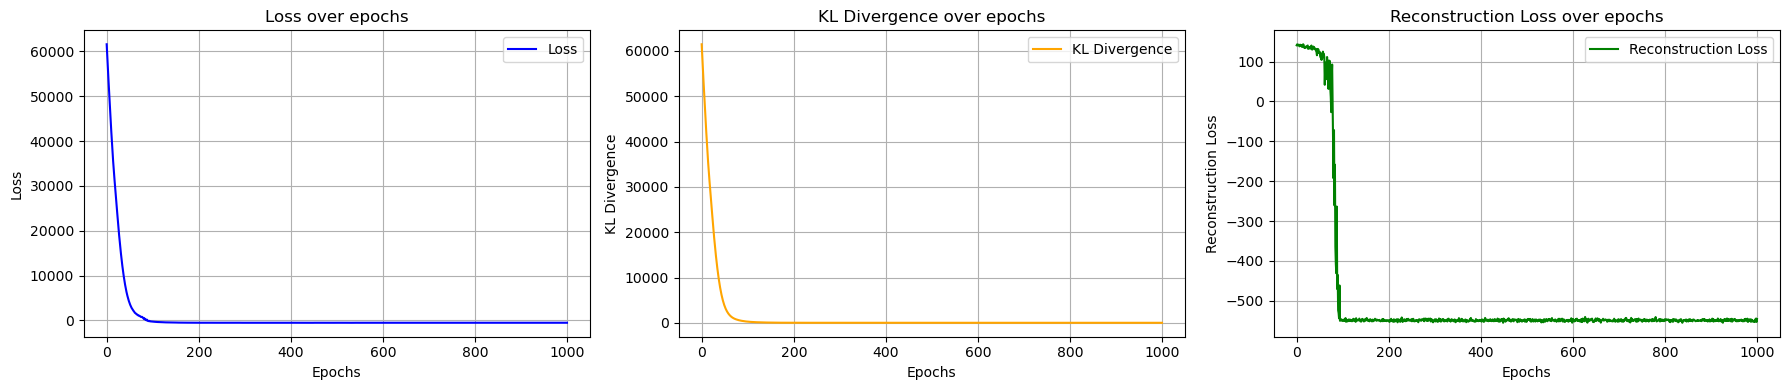

In [342]:
fig, ax = plt.subplots(1,3, figsize=(18, 4))

ax[0].plot(losses, label='Loss', color='blue')
ax[0].set_title('Loss over epochs')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(kls, label='KL Divergence', color='orange')
ax[1].set_title('KL Divergence over epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('KL Divergence')
ax[1].grid(True)
ax[1].legend()

ax[2].plot(reconstruction_losses, label='Reconstruction Loss', color='green')
ax[2].set_title('Reconstruction Loss over epochs')
ax[2].set_xlabel('Epochs')      
ax[2].set_ylabel('Reconstruction Loss')
ax[2].grid(True)
ax[2].legend()

plt.tight_layout()
plt.show()

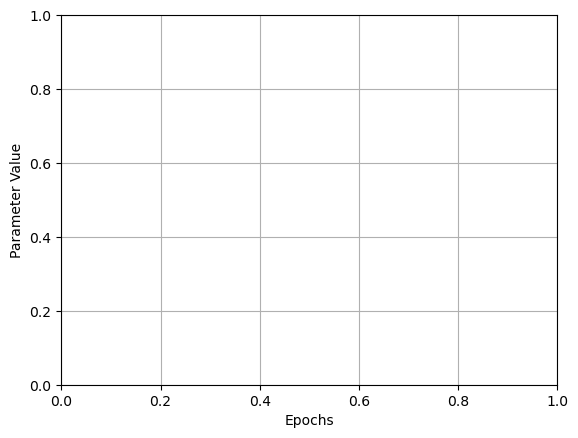

In [343]:
for name, values in prior_mean.named_parameters():
    plt.plot(mean_params[name], label=name)
    plt.ttile(f'Prior Mean Parameter: {name}')
# plt.title('Prior Mean Parameters over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Parameter Value')
plt.grid(True)
plt.show()

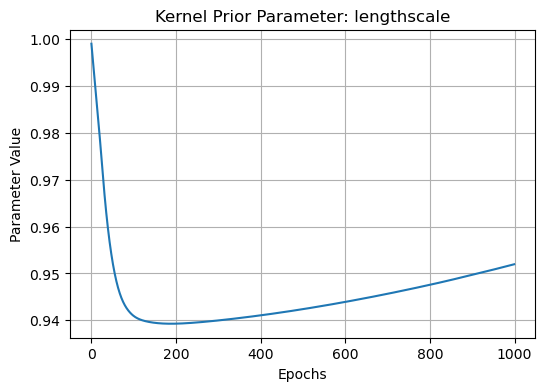

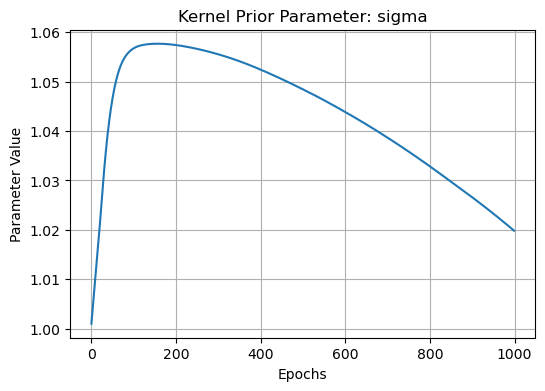

In [344]:
for name, values in prior_kernel.named_parameters():
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(kernel_params[name], label=name)
    ax.set_title(f'Kernel Prior Parameter: {name}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Parameter Value')
    ax.grid(True)
    plt.show()

Predictions

In [345]:
z_sampled = p_theta_z.rsample()  # (K, B, N, Dz)

In [346]:
mu_x = decoder_mean(z_sampled.unsqueeze(-1))  # (B, N, Dx)
mu_x = mu_x.squeeze(2)  # (B, N)

logvar_x = decoder_logvar(z_sampled)  # (B, N, Dx)
covar_x = torch.diag_embed(logvar_x.exp())  # (B, N, Dx, Dx)

p_theta_x = torch.distributions.MultivariateNormal(
        loc=mu_x,
        covariance_matrix=covar_x
    )

In [347]:
x_hat = p_theta_x.rsample()  # (K, B, L, Dx)

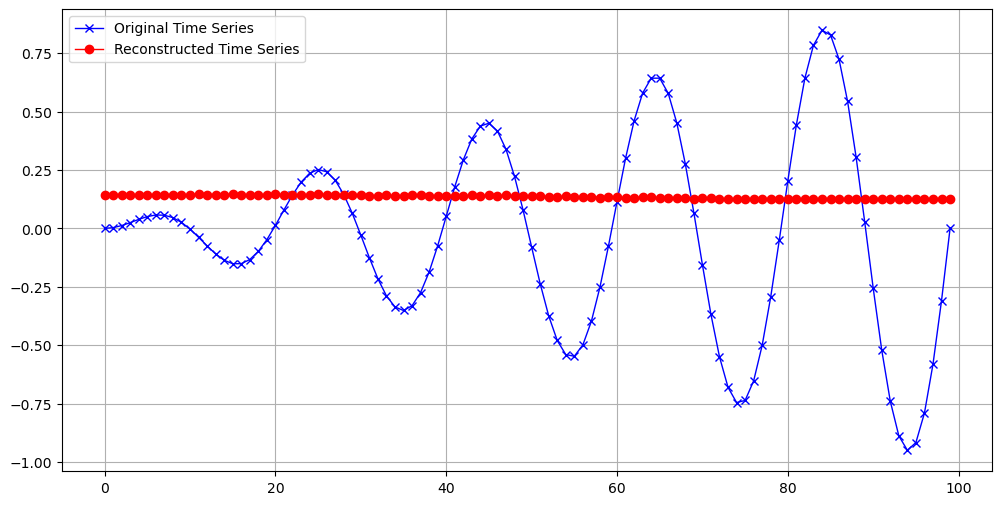

In [350]:
fig, ax = plt.subplots(figsize=(12, 6))
# Plot the original time series

ax.plot(x[0, :].detach().cpu().numpy(), label='Original Time Series', color='blue', marker='x', linewidth=1)
# Plot the reconstructed time series
ax.plot(mu_x[0, :].detach().cpu().numpy(), label='Reconstructed Time Series', color='red', marker='o', linewidth=1)
# ax.plot(x_hat[0, :].detach().cpu().numpy(), label='Sampled Time Series', color='green', marker='s', linewidth=1)

ax.grid(True)
ax.legend()
plt.show()